<center><h1>Практическая работа №5</h1></center>

<center><h2>Тема работы: "Подготовочный анализ данных и прогнозирование признаков"</h2></center>

<h5>Цель работы: обучить модель линейной регрессии для прогнозирования стоимости автомобиля на основе его технических характеристик и оценить качество полученных предсказаний с помощью статистических метрик.</h5>

<h5>Ход работы:</h5>

<h4>1. Загрузка данных и первичный анализ.</h4>
<h5>В данном блоке загружаются данные из CSV-файла и проводится первичная проверка их целостности. Определяется размерность таблицы и ищется пропущенные значения, которые могут помешать обучению модели.</h5>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
path = r"A:\\Programs\\M VS Code projects\\jupyter\\IPYNB-machine-learning\\cardekho.csv"
df = pd.read_csv(path) # загружает данные из CSV-файла в DataFrame pandas
df.info() # выводит сводную информацию о DataFrame: структуру, типы данных и количество ненулевых значений

<class 'pandas.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   str    
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   str    
 5   seller_type         8128 non-null   str    
 6   transmission        8128 non-null   str    
 7   owner               8128 non-null   str    
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   str    
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), str(6)
memory usage: 762.1 KB


In [ ]:
# Исследование структуры
print(f"Количество строк: {df.shape[0]}") # shape[0] — возвращает количество строк
print(f"Количество столбцов: {df.shape[1]}") # shape[1] — возвращает количество столбцов
print("\nПропущенные значения:") 
print(df.isnull().sum()) # isnull().sum() — считает количество пустых ячеек для каждого столбца

# Статистический анализ
print("\nСтатистические показатели:")
print(df.describe()) # describe() — выводит среднее, минимум, максимум и квантили для чисел

# Очистка: преобразуем мощность в числа, ошибки (текст) станут NaN, затем удаляем их
df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce') 
df_clean = df.dropna(subset=['max_power', 'selling_price']) # dropna — удаляет строки с пропусками (NaN)

Количество строк: 8128
Количество столбцов: 12

Пропущенные значения:
name                    0
year                    0
selling_price           0
km_driven               0
fuel                    0
seller_type             0
transmission            0
owner                   0
mileage(km/ltr/kg)    221
engine                221
max_power             215
seats                 221
dtype: int64

Статистические показатели:
              year  selling_price     km_driven  mileage(km/ltr/kg)  \
count  8128.000000   8.128000e+03  8.128000e+03         7907.000000   
mean   2013.804011   6.382718e+05  6.981951e+04           19.418783   
std       4.044249   8.062534e+05  5.655055e+04            4.037145   
min    1983.000000   2.999900e+04  1.000000e+00            0.000000   
25%    2011.000000   2.549990e+05  3.500000e+04           16.780000   
50%    2015.000000   4.500000e+05  6.000000e+04           19.300000   
75%    2017.000000   6.750000e+05  9.800000e+04           22.320000   
max    20

<h4>2. Визуализация данных.</h4>
<h5>Для понимания структуры данных строится гистограммы распределения целевой переменной и признаков. Тепловая карта корреляции позволяет математически обосновать выбор наиболее влиятельного фактора для построения регрессии.</h5>

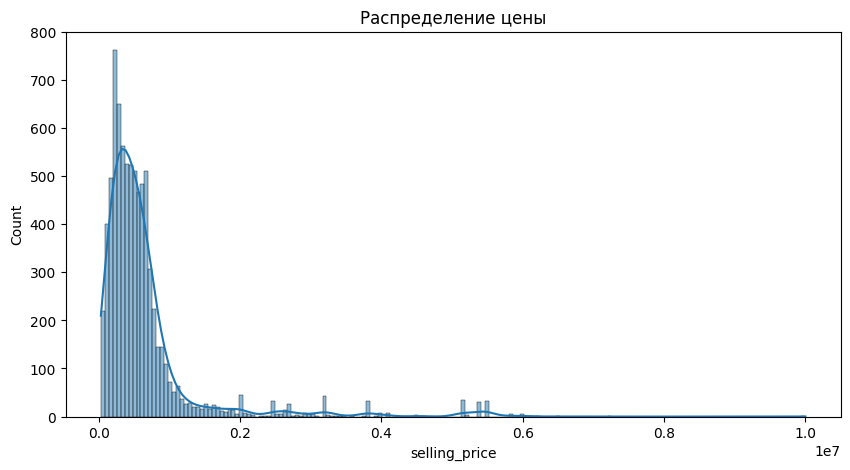

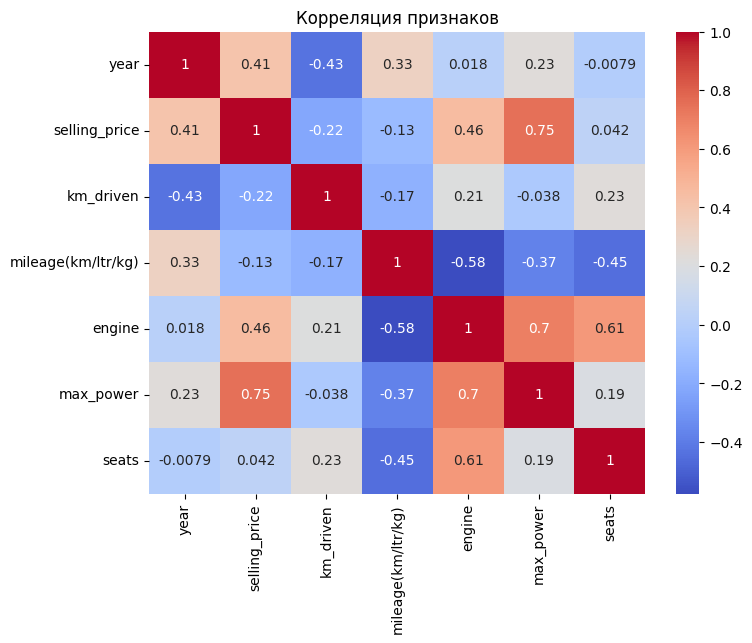

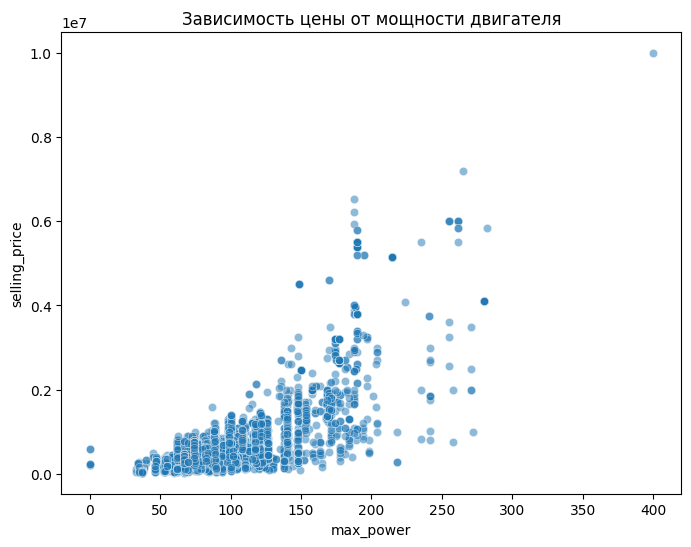

In [4]:
# Гистограмма распределения цены
plt.figure(figsize=(10, 5)) # figsize=(10, 5) — задает ширину 10 и высоту 5 дюймов для окна графика
sns.histplot(df_clean['selling_price'], kde=True) # kde=True — рисует плавную линию оценки плотности поверх столбцов
plt.title('Распределение цены')
plt.show() # show() — выводит график на экран и очищает текущую область рисования

# Тепловая карта корреляции
plt.figure(figsize=(8, 6))
# corr(numeric_only=True) — вычисляет коэффициент Пирсона только для числовых столбцов
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm') # annot=True — пишет значения внутри ячеек
plt.title('Корреляция признаков')
plt.show()

# График парной корреляции (Scatterplot) между выбранными признаками
plt.figure(figsize=(8, 6))
# scatterplot рисует точки на плоскости (x — независимая переменная, y — зависимая)
sns.scatterplot(data=df_clean, x='max_power', y='selling_price', alpha=0.5) 
plt.title('Зависимость цены от мощности двигателя')
plt.show()

# Выбранные переменные: max_power (мощность) как предиктор, selling_price (цена) как цель

<h4>3. Разделение данных на обучающую и тестовую выборки.</h4>
<h5>Выделяем целевой признак и обучающий фактор в отдельные переменные. Разделение на выборки необходимо, чтобы проверить модель на данных, которые она не видела в процессе обучения, исключая переобучение.</h5>

In [5]:
X = df_clean[['max_power']] # Признак (матрица, поэтому двойные скобки)
y = df_clean['selling_price'] # Целевая переменная (вектор)

# train_test_split разделяет данные: test_size=0.2 — это 20% данных на тест, random_state=42 — для фиксации результата
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h4>4. Реализация и обучение модели линейной регрессии.</h4>
<h5>На этом этапе создается экземпляр модели, который "подгоняется" под обучающие данные. После обучения мы используем тестовый набор для получения предсказаний и вычисления метрик точности: RMSE, MAE и R2.</h5>

In [ ]:
model = LinearRegression() # Инициализация объекта модели
model.fit(X_train, y_train) # fit() — процесс обучения (подбор коэффициентов уравнения прямой)

y_pred = model.predict(X_test) # predict() — вычисление предсказаний на основе признаков из тестовой выборки

# Расчет метрик

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}") # MAE — средняя абсолютная ошибка (на сколько в среднем рублей ошибается модель)
# RMSE - Разница между ценой и прогнозом возводится в квадрат. Из-за этого маленькие ошибки остаются маленькими, а большие — становятся огромными.
# В конце извлекается корень, чтобы вернуть число к обычным рублям.
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}") # sqrt — корень из среднеквадратичной ошибки
# R2 показывает, какую долю закономерностей в данных модель смогла уловить (процент качества)
print(f"R2: {r2_score(y_test, y_pred):.4f}") # r2_score — коэффициент детерминации (точность модели от 0 до 1)

MAE: 303414.34
RMSE: 507979.94
R2: 0.5635


<h4>5. Визуализация результатов прогнозирования.</h4>
<h5>Графическая визуализация позволяет наглядно сравнить предсказанные значения с реальными. Линия регрессии показывает общую закономерность, которую выявила модель в облаке точек данных.</h5>

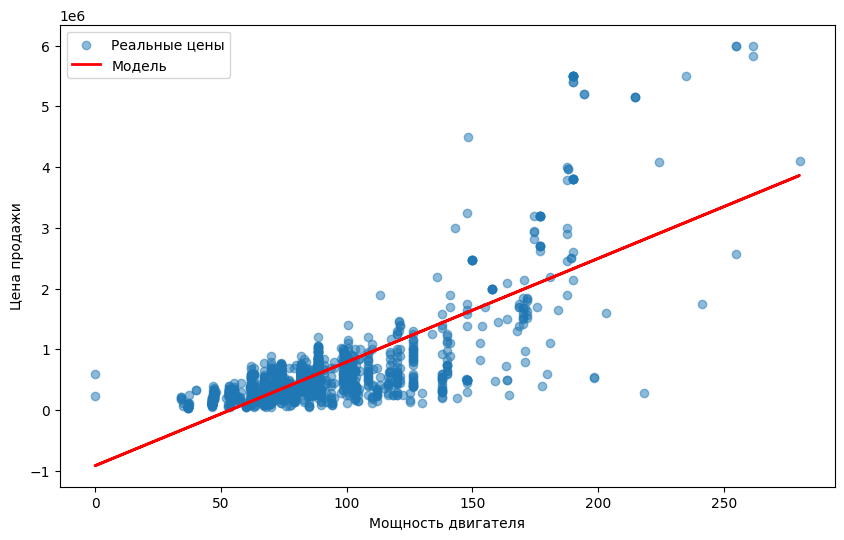

In [7]:
plt.figure(figsize=(10, 6))
# scatter() — рисует точки; alpha=0.5 — делает их полупрозрачными для наглядности плотности
plt.scatter(X_test, y_test, alpha=0.5, label='Реальные цены') 
# plot() — рисует линию; color='red' — выделяет предсказание модели красным цветом
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Модель') 
plt.xlabel('Мощность двигателя')
plt.ylabel('Цена продажи')
plt.legend() # legend() — выводит подписи (label) в углу графика
plt.show()

<h5>Вывод: в ходе выполнения работы была успешно реализована модель линейной регрессии, которая позволила выявить значимую зависимость стоимости автомобиля от мощности его двигателя. На основе полученных метрик (R^2, MAE) можно сделать вывод, что выбранный признак объясняет большую часть ценообразования, хотя для более точных прогнозов требуется учет дополнительных факторов.</h5>